In [160]:
import visa
import time
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [161]:
rm = visa.ResourceManager()
gpc = rm.open_resource('GPIB::23::INSTR',read_termination='\r\n')



#change these variables to the path where you want your file saved and its name
path = 'D:/TunnelDiodeSNR/'
filename = 'noiseDiode6ENR_VHF30-300MHz.txt'

dv = 0.001 # 1 mV #smallest resolution = 0.02 mV
dmax = .250 # 10 mV; later use 50 mV

In [162]:
gpc.write("CM0") #counting mode A,B for T Preset
gpc.write("CI0") #counter A to input 1
gpc.write("CP2,0") #counter T to 10 MHz
gpc.write("CP2,1e7") #set T Set to 1s 
#note: T set is the number of cycles of the 10MHz clock, not seconds
N = 100 #int(np.ceil(dmax/dv))
gpc.write('NP'+str(N)) #set number of periods
gpc.write('DM0,0') #set discriminator mode to fixed



(7, <StatusCode.success: 0>)

In [163]:
#n = gpc.write('NP100')
#print(n)
n1 = gpc.query('DL0,0')
print(n1)

1


In [174]:
gpc.write("DCL")
gpc.write("CR;CS")
#time.sleep(1)
'''ss = gpc.query("SS")
print(ss)
if( len(ss) == 1):
    print(bin(ord(ss))[2:][1])
'''
ss = 0
while ( int(ss) != 1 ):
    ss = gpc.query("SS1")
    #print('Status bit 1 %s'%ss)
    #count = gpc.query("QA")
#ss = gpc.query("SS1")
#print('Status bit 1')
#print(ss,len(ss))
count = gpc.query("QA")
print("Count %s"%count)
ss = gpc.query("SS1")
print('Status bit 1')
print(ss,len(ss))

print(count)
ss = gpc.query("SS1")
ss0 = gpc.query("SS0")
print('Status bit 1')
print(ss,len(ss))
print('Status bit 0')
print(ss0,len(ss0))
print(type(ss))

Count 46
Status bit 1
0 1
46
Status bit 1
0 1
Status bit 0
0 1
<class 'str'>


In [53]:
file = open(path + filename, 'w')
file.write('Discriminator Level (V), Counts\n')

D = np.arange(0,dmax+dv,dv)
gpc.write("DL0,0") #set discriminator threshold to zero
    
for i in D:
    #print('go to level'+str(i))
    gpc.write("DL0,"+str(i))
    #disc = gpc.query("DZ0") #reads discriminator value
    #print('level = '+ disc)

    gpc.write('CR;CS') # start the scan
    time.sleep(2)
    
    j = 0;
    while j < 1:
        #ss = -1
        #while ss != "0":
         #   ss = gpc.query("SS1") # wait for the photon counter to be ready
          #  print('ss'+ss)
    #Now read the counter
        A  = gpc.query("QA1")
        #print('A'+A)
        if np.float(A) >= 0:
            break
        else:
            continue
    #time.sleep(.)        

    #add period here?
    
    print('disc level: '+str(i*10**3)+' (mV),  counts: '+A)
    file.write(str(i)+','+A+'\n')
    time.sleep(.5)

file.close()
    


disc level: 0.0 (mV),  counts: 0
disc level: 1.0 (mV),  counts: 0


KeyboardInterrupt: 

C:\Users\Anita\anaconda3\lib\site-packages\matplotlib\axes\_base.py:3245: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


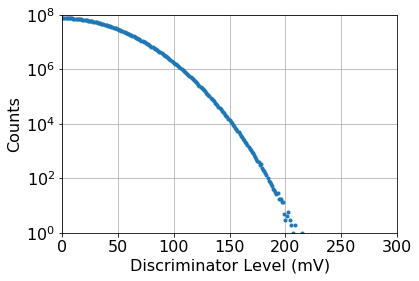

In [52]:
df = pd.read_csv(path+filename, sep = ',')

disc = df['Discriminator Level (V)'] 
counts = df[' Counts'] 
fig1 = plt.figure(1)
plt.rcParams['font.size']=16
plt.semilogy(disc*10**3,counts,'.')
plt.ylim(0,max(counts)+ .25*max(counts))
plt.xlim(0,300)
plt.grid(True)
plt.xlabel('Discriminator Level (mV)')
plt.ylabel('Counts')

plt.show()
plt.savefig(path+"noiseDiode6ENR_VHF30-300MHz_.pdf", bbox_inches='tight')

Text(0.5,1,'Pulser 0.5 MHz, 0.8 SNR, Amp after TD')

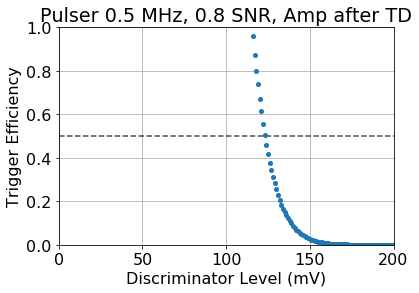

In [53]:
df = pd.read_csv(path+filename, sep = ',')

disc = df['Discriminator Level (V)'] 
counts = df[' Counts'] 

pulser_period = 2e-6 # 2 microseconds between triggers
pulser_rep_rate = 1./pulser_period
count_time = 1 # second
expected_counts = count_time * pulser_rep_rate

fig1 = plt.figure(1)
plt.rcParams['font.size']=16
plt.plot(disc*10**3,counts/expected_counts,'.', markersize=8)
plt.ylim(0,1)
plt.xlim(0,200)
plt.grid(True)
plt.hlines(0.5, 0,300, linestyle='--', alpha=0.7)
plt.xlabel('Discriminator Level (mV)')
plt.ylabel('Trigger Efficiency')
plt.title("Pulser %2.1f MHz, 0.8 SNR, Amp after TD"%(pulser_rep_rate/1e6))
#plt.show()
#plt.savefig(path+"SNR5_amp_threshold_example_eff.pdf", bbox_inches='tight')